Mandelbrot created on GPU in 0.20876860618591309 seconds


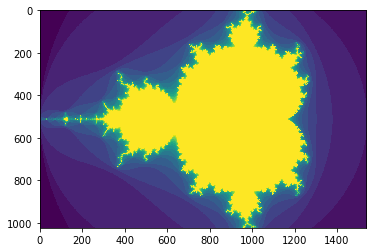

In [2]:
# %load mandel.py
#!/bin/env python3
from numba import cuda
import numpy as np
import matplotlib.pyplot as P
import time

@cuda.jit(device=True)
def mandel(x, y, max_iters):
  """
  Given the real and imaginary parts of a complex number,
  determine if it is a candidate for membership in the Mandelbrot
  set given a fixed number of iterations.
  """
  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i

  return max_iters

@cuda.jit
def mandel_kernel(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height

  startX = cuda.blockDim.x * cuda.blockIdx.x + cuda.threadIdx.x
  startY = cuda.blockDim.y * cuda.blockIdx.y + cuda.threadIdx.y
  gridX = cuda.gridDim.x * cuda.blockDim.x;
  gridY = cuda.gridDim.y * cuda.blockDim.y;

  for x in range(startX, width, gridX):
    real = min_x + x * pixel_size_x
    for y in range(startY, height, gridY):
      imag = min_y + y * pixel_size_y 
      image[y, x] = mandel(real, imag, iters)

gimage = np.zeros((1024, 1536), dtype = np.uint8)
blockdim = (32, 8)
griddim = (32,16)

start = time.time()
d_image = cuda.to_device(gimage)
mandel_kernel[griddim, blockdim](-2.0, 1.0, -1.0, 1.0, d_image, 20) 
d_image.to_host()
dt = time.time() - start

print("Mandelbrot created on GPU in",dt,"seconds")

P.imshow(gimage);
